In [8]:
import utils
utils.assign_free_gpus()
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

No GPU available, using CPU


/bin/sh: nvidia-smi: command not found


### Dataset

In [9]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 28, 28]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: 0.0


In [10]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 10)
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [11]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [12]:
# Hyperparameters
learning_rate = .0192
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

In [13]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4: 100%|██████████| 938/938 [00:01<00:00, 537.11it/s]


### Task A

In [14]:
# Using the model trained above as the non normalized images model

# Create normalized image data set and train model on it
torch.random.manual_seed(0)
np.random.seed(0)

normalized_image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = 0.5, std = 0.5),
])
normalized_train, normalized_test = dataloaders.load_dataset(batch_size, normalized_image_transform)
normalized_model = create_model()
optimizer = torch.optim.SGD(normalized_model.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=normalized_model,
  dataloader_train=normalized_train,
  dataloader_test=normalized_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
normalized_train_loss_dict, normalized_test_loss_dict = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:02<00:00, 344.85it/s]


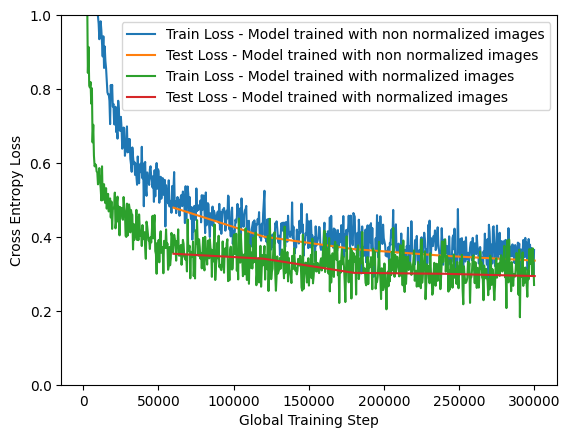

Final Test loss: 0.3358317878643039. Final Test accuracy: 0.9084


In [15]:
# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss - Model trained with non normalized images")
utils.plot_loss(test_loss_dict, label="Test Loss - Model trained with non normalized images")
utils.plot_loss(normalized_train_loss_dict, label="Train Loss - Model trained with normalized images")
utils.plot_loss(normalized_test_loss_dict, label="Test Loss - Model trained with normalized images")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a_normalized.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task B

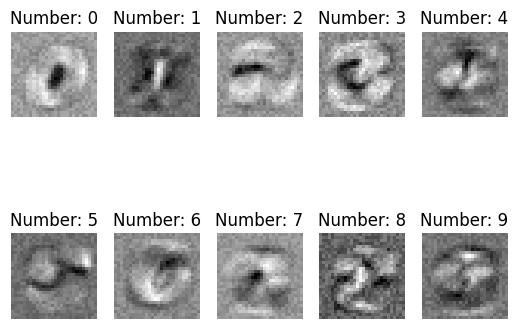

In [16]:
weight = list(normalized_model.children())[1].weight.cpu().data
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(weight[i].reshape(28,28), cmap='gray')
    plt.title(f'Number: {i}')
    plt.axis('off')
plt.savefig("image_solutions/task_4a_weights.png")



### Task C

In [17]:
# Create model trained with learning rate 1
torch.random.manual_seed(0)
np.random.seed(0)
learning_rate = 1.0

fast_train, fast_test = dataloaders.load_dataset(batch_size, normalized_image_transform)
fast_model = create_model()
optimizer = torch.optim.SGD(fast_model.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=fast_model,
  dataloader_train=fast_train,
  dataloader_test=fast_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
fast_train_loss_dict, fast_test_loss_dict = trainer.train(num_epochs)

Training epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4: 100%|██████████| 938/938 [00:02<00:00, 346.65it/s]


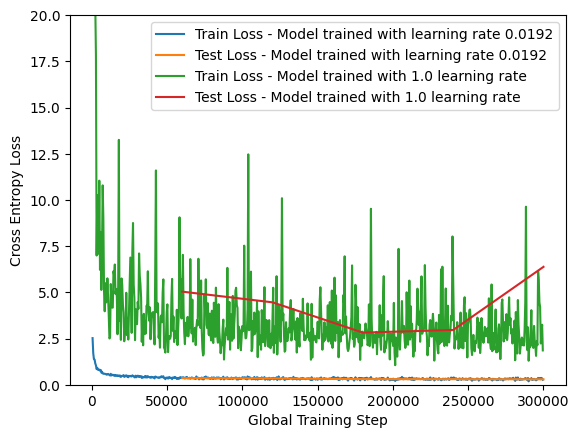

Final Test loss: 0.3358317878643039. Final Test accuracy: 0.9084


In [18]:
# Plot loss
utils.plot_loss(normalized_train_loss_dict, label="Train Loss - Model trained with learning rate 0.0192")
utils.plot_loss(normalized_test_loss_dict, label="Test Loss - Model trained with learning rate 0.0192")
utils.plot_loss(fast_train_loss_dict, label="Train Loss - Model trained with 1.0 learning rate")
utils.plot_loss(fast_test_loss_dict, label="Test Loss - Model trained with 1.0 learning rate")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 20])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4c.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task D

In [19]:
def create_model_2():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 6000),
        nn.ReLU(),
        nn.Linear(6000, 10)

        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model_2()

In [20]:
# Create model trained with learning rate 1
torch.random.manual_seed(0)
np.random.seed(0)
learning_rate = 0.0192

hidden_train, hidden_test = dataloaders.load_dataset(batch_size, normalized_image_transform)
hidden_model = create_model_2()
optimizer = torch.optim.SGD(hidden_model.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=hidden_model,
  dataloader_train=hidden_train,
  dataloader_test=hidden_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
hidden_train_loss_dict, hidden_test_loss_dict = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:06<00:00, 139.41it/s]


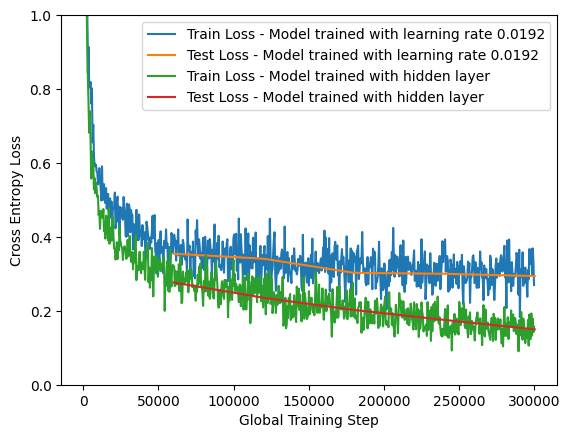

Final Test loss: 2.3033795463051767. Final Test accuracy: 0.0966


In [21]:
# Plot loss
utils.plot_loss(normalized_train_loss_dict, label="Train Loss - Model trained with learning rate 0.0192")
utils.plot_loss(normalized_test_loss_dict, label="Test Loss - Model trained with learning rate 0.0192")
utils.plot_loss(hidden_train_loss_dict, label="Train Loss - Model trained with hidden layer")
utils.plot_loss(hidden_test_loss_dict, label="Test Loss - Model trained with hidden layer")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4d.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")